# Let's play with the moving boundary condition!

**Are we in SWAN?**

In [ ]:
%pip install --user crank-nicolson-numba

**Do we want the matplotlib interactive magicness?**

In [1]:
%matplotlib widget

**Library Import**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate
from tqdm.notebook import tqdm
import crank_nicolson_numba.generic as cn
import itertools
# For parallelization
from joblib import Parallel, delayed

import nekhoroshev_tools as nt

## First, we need to define a realistic initial distribution

It's very simple and direct: if we decide to work in normalized emittance variables, and we work with a gaussian beam distribution with it's characteristic emittance, we have that
$$\rho_0(I) = e^{-I}$$
Where $I$, from now on, is expessed in sigma units.

In [2]:
def rho_0(I, damping_position=np.nan, l=np.nan):
    if np.isnan(damping_position) or np.isnan(l):
        return np.exp(-I)
    else:
        return np.exp(-I) / (1 + np.exp((I - damping_position)/l))

## Working constants

In [3]:
I_damping = 9.8
I_max = 10.0
I_star = 20.0
k = 0.33
exponent = 1/(2*k)

c = nt.standard_c(0.0, I_max, I_star, exponent)

In [4]:
cn_sampling = 50000
I_list, dI = np.linspace(0.0, I_max, cn_sampling, retstep=True)

cn_time_steps = 100
dt = nt.current_peak_time(I_damping, I_max, I_star, exponent, c)/cn_time_steps

**Values our specific analysis**

In [5]:
steps_per_sample = 100

steps_per_iteration = 500
iterations = 4
long_track_steps = steps_per_iteration * iterations

## How's the regular current for a single, constant $I_a$?

In [6]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))
data_0 = engine.get_data_with_x()

times_long, current_long = engine.current(long_track_steps, steps_per_sample, False)
data_long = engine.get_data_with_x()

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)
100%|██████████| 2000/2000 [03:37<00:00,  9.21it/s]


**That's how our distribution (slowly) evolves...**

(In order to see things it's necessary to work with matplotlib interactive mode and zoom a lot)

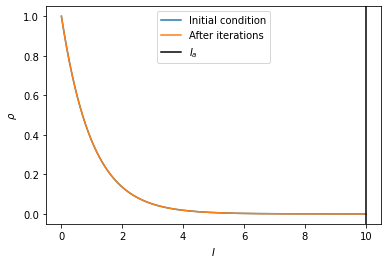

In [7]:
plt.figure()
plt.plot(data_0[0], data_0[1], label="Initial condition")
plt.plot(data_long[0], data_long[1], label="After iterations")
plt.axvline(I_max, color="black", label="$I_a$")
plt.xlabel("$I$")
plt.ylabel("$\\rho$")
plt.legend()

**And here's the current!**

Text(0, 0.5, '$J$')

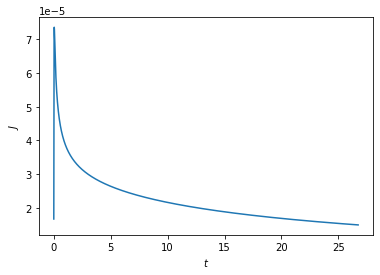

In [8]:
plt.figure()
plt.plot(times_long, current_long)
plt.xlabel("$t$")
plt.ylabel("$J$")

## And what happens when we have $I_a$ moving outwards?

In [9]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))

t_out = []
c_out = []

for i in tqdm(range(iterations)):
    time, current = engine.current(steps_per_iteration, steps_per_sample)
    if len(t_out) > 0:
        time += t_out[-1][-1]
    t_out.append(time)
    c_out.append(current)
    engine.move_barrier_forward(0.1)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


  0%|          | 0/4 [00:00<?, ?it/s]

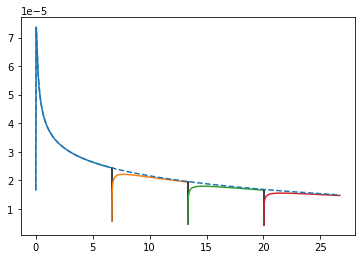

In [10]:
plt.figure()

for i in range(iterations):
    plt.plot(t_out[i], c_out[i])
    if i != iterations - 1:
        plt.plot([t_out[i][-1], t_out[i][-1]], [c_out[i][-1], c_out[i+1][0]], c="black")

plt.plot(times_long, current_long, c="C0", linestyle="dashed")

## And what happens when we have $I_a$ moving inwards?

In [11]:
engine = cn.cn_generic(0, I_max, rho_0(I_list, I_damping, dI*5), dt, lambda x: nt.D(x, I_star, exponent, c, True))

t_in = []
c_in = []

for i in tqdm(range(iterations)):
    time, current = engine.current(steps_per_iteration, steps_per_sample)
    if len(t_in) > 0:
        time += t_in[-1][-1]
    t_in.append(time)
    c_in.append(current)
    engine.move_barrier_backward(0.1)

/home/camontan/Insync/carlo.montanari3@studio.unibo.it/OneDrive_Biz/projects/new_games_with_diffusion/nekhoroshev_tools.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  return c * np.exp(-2*np.power(I_star/I, exponent)) * (0.5 if halved else 1.0)


  0%|          | 0/4 [00:00<?, ?it/s]

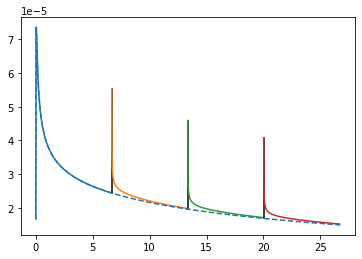

In [12]:
plt.figure()

for i in range(iterations):
    plt.plot(t_in[i], c_in[i])
    if i != iterations - 1:
        plt.plot([t_in[i][-1], t_in[i][-1]], [c_in[i][-1], c_in[i+1][0]], color="black")

plt.plot(times_long, current_long, c="C0", linestyle="dashed")

## How's the known and observed behaviour in experimental literature?

### From LHC beam halo dynamics paper:
![scheme](./ext_figs/literature_1.png)

### From Stancari's paper:
![scheme2](./ext_figs/literature_2.png)

### Quick basic remarks

* We can observe good similarities with the behaviour in our model and the established experimental data:
    1. When we have an outward step, the current has a big dip and then a fast recover to the original current;
    2. When we have an inward step, the current has a big peak (N.B. here we are neglecting the beam part cutted away in the process, but it can be considered and included in the plot), and then a fast relaxation to the original current;
* There is just an element that extremely differs from the experimental data, the big change in module in the signal depending on the jaw position. Can this be related to the different closure of the jaws at the different positions?